## Preference-Based Recommendation System for Groups

Algorithmic Marketing Class Project

Name: Li Liu, Suresh Govindaraj, Xi Zhao

Date: March 2020

A group of people wanted to have an amazing restaurant dining experience in Las Vegas. Some of them were attracted by a French restaurant 30 min away. Some of them thought the nearby sushi place was good enough. They opened Yelp and set the filters. But it didn't help them decide because the app showed each of them very different results.

Here comes our system. We want to help them decide which ones work best for them all.

Using our utility maximization framework, our system recommends the restaurants that will most likely maximize their total utilities.

Suppose we have three people: A, B, C are choosing from N restaurants (R indicates restaurants factors).

For each restaurant i (i=1...N), each person would have a utility for i: $u_A(R_i)$, $u_B(R_i)$, $u_C(R_i)$

We need to have a match function for predicting the total utilities from eating at this restaurant, such that $m_{R_i}(A,B,C) = U_{i}(u(R_i), R_i, Weights, Preferences)$

Our core algorithm will account for the following factors:

* Each restaurant has a baseline utility for the group (Think of $\beta_0$). We use machine learning to predict this utility by using the existing _**Yelp reviews data**_.

Then we will use _**users' input data**_ to adjust the baseline utility based on the groups' preferences and consensus ($\sum_k(\prod_m(p_m*w_m)X_k)$): 

* People have different voting weights (Ex. parents make the final decision instead of kids)

* People have own preferences (Ex. not important at all, neutral, very important)

* People care about others. The total utility depends on others' preference. If A knows B and C hate pizza, the utility for A to choose a pizza place will be lower than the case if A dining alone. 

When A, B, C open the system, they will be asked to choose their preferences for distance and cuisine types. If the factor is not important for A at all, the $p_{A}=0.1$. If the factor is neutral for A, the $p_{A}=0.5$. If the factor is very important for A, the $p_{A}=1$. Also, they have different voting weights w, $w_A, w_b, w_C$, and $w_A+w_b+w_C=1$, 

Generally, suppose we have M (m=1...M) people to choose from N (i=1...N) restaurants and the system asks them to answer K (k=1...K) questions:

$$U_{i} = \beta_0 + \beta_1X_1+ \beta_2X_2+...+\beta_kX_k+\epsilon$$
$$\hat{U_{i}}= \hat{f}(Restaurant Reputations, Weekend, Group...) + \sum_k(\prod_m(p_m*w_m)X_k)$$

Then we have scores for all restaurants from i=1 to N. We can sort them and recommend the top ones for the group.

#### Import packages

In [541]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import six
import statsmodels.api as sm
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
sns.set_style("white")
plt.style.use('seaborn-deep')

start=time.time()

#### Read in data

In [542]:
# review 
rev = pd.read_csv("yelp_review.csv")
print("total review text", rev.shape)
rev.head(2)

total review text (5261668, 9)


,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0


#### Subset the data 

1. Only restaurants in Las Vegas

2. Join data from business and users

In [543]:
# business
bus = pd.read_csv("yelp_business.csv")
print("total business",bus.shape)

# select restaurants in LV
LV = bus[bus["city"] == "Las Vegas"]
LVR = LV[LV['categories'].str.contains('Restaurants') == True] 

# select only open restaurants; drop uninformative features
LVR = LVR[LVR["is_open"] == 1]
LVR = LVR.drop(["city", "state", "postal_code", "is_open"], axis = 1)

print("total open restaurants", LVR.shape)

total business (174567, 13)
total open restaurants (3990, 9)


In [544]:
LVR.head()

,business_id,name,neighborhood,address,latitude,longitude,stars,review_count,categories
52,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,Nightlife;Bars;Barbeque;Sports Bars;American (...
53,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Southeast,"""6889 S Eastern Ave, Ste 101""",36.064652,-115.118954,2.5,6,Fast Food;Restaurants;Sandwiches
54,n7V4cD-KqqE3OXk0irJTyA,"""GameWorks""",Southeast,"""6587 Las Vegas Blvd S, Ste 171""",36.068259,-115.178877,3.0,349,Arcades;Arts & Entertainment;Gastropubs;Restau...
122,Wpt0sFHcPtV5MO9He7yMKQ,"""McDonald's""",Eastside,"""3020 E Desert Inn Rd""",36.130013,-115.109310,2.0,20,Restaurants;Fast Food;Burgers
133,W1Yr6c2XDx_RBjb6WsV-aQ,"""Divine Cafe at the Springs Preserve""",Westside,"""333 S Valley View Blvd""",36.170706,-115.190288,4.0,140,Restaurants;Cafes;American (New);Bars;Nightlif...


In [545]:
# user data
user = pd.read_csv("yelp_user.csv")
user.shape

(1326100, 22)

In [546]:
user.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'useful',
       'funny', 'cool', 'fans', 'elite', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

##### Aggregate data 
Each line represents a review for a restaurant by one user

In [547]:
agg = pd.merge(LVR, rev, how = "left", on = "business_id")
agg = pd.merge(agg, user, how = "left", on = "user_id")
agg.rename(columns = {'stars_x':"star_bus", "review_count_x": "cts_bus",
                      "stars_y": "star_customer"},
           inplace = True)
agg.shape

(795588, 38)

##### Only keep the most relevant reviews

Restaurants normally update and improve products and services constantly to satisfy customers' needs, especially at Las Vegas. We will only keep the reviews in the last year.

In [548]:
agg["DATE"] = pd.to_datetime(agg["date"], format = '%Y/%m/%d')
agg["date_yr"] = agg["DATE"].dt.year
agg["date_mt"] = agg["DATE"].dt.month

In [549]:
agg["DATE"].describe()

count                  795588
unique                   4317
top       2017-08-12 00:00:00
freq                      766
first     2005-01-26 00:00:00
last      2017-12-11 00:00:00
Name: DATE, dtype: object

In [550]:
agg = agg[agg["date_yr"]>=2017]
agg.shape

(181144, 41)

In [551]:
# skim data
agg.head(5)

,business_id,name_x,neighborhood,address,latitude,longitude,star_bus,cts_bus,categories,review_id,...,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,DATE,date_yr,date_mt
0,Pd52CjgyEU3Rb8co6QfTPw,"""Flight Deck Bar & Grill""",Southeast,"""6730 S Las Vegas Blvd""",36.066914,-115.170848,4.0,13,Nightlife;Bars;Barbeque;Sports Bars;American (...,aG4aEOW86hut943oqL_DOg,...,0,0,2,1,1,0,0,2017-03-27,2017,3
14,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Southeast,"""6889 S Eastern Ave, Ste 101""",36.064652,-115.118954,2.5,6,Fast Food;Restaurants;Sandwiches,FMRzUXMwjx8vPAy-qgej7A,...,0,22,144,82,82,18,53,2017-09-27,2017,9
17,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Southeast,"""6889 S Eastern Ave, Ste 101""",36.064652,-115.118954,2.5,6,Fast Food;Restaurants;Sandwiches,qLb9CBAIbWcQ3aBoYjc3nQ,...,0,1,3,2,2,2,3,2017-09-14,2017,9
18,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Southeast,"""6889 S Eastern Ave, Ste 101""",36.064652,-115.118954,2.5,6,Fast Food;Restaurants;Sandwiches,b-hPwDTtvj27RTwotZo9Gg,...,0,0,0,0,0,0,0,2017-09-28,2017,9
23,n7V4cD-KqqE3OXk0irJTyA,"""GameWorks""",Southeast,"""6587 Las Vegas Blvd S, Ste 171""",36.068259,-115.178877,3.0,349,Arcades;Arts & Entertainment;Gastropubs;Restau...,HVeoYQNl-O1ufTwkHLgtsg,...,0,0,0,0,0,0,0,2017-03-03,2017,3


In [552]:
# current columns
agg.columns

Index(['business_id', 'name_x', 'neighborhood', 'address', 'latitude',
       'longitude', 'star_bus', 'cts_bus', 'categories', 'review_id',
       'user_id', 'star_customer', 'date', 'text', 'useful_x', 'funny_x',
       'cool_x', 'name_y', 'review_count_y', 'yelping_since', 'friends',
       'useful_y', 'funny_y', 'cool_y', 'fans', 'elite', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos', 'DATE', 'date_yr', 'date_mt'],
      dtype='object')

###   Predicted utility: rescaled satisfaction scores

`star_customer` is customers' rating for a restaurant.

`average_stars` is customers' average rating for all teh restaurants they have reviewed.


We use the reweighed and rescaled `star_customer` to measure the customer satisfaction. 

In [553]:
# individual ratings for particular restaurants are positive correlated with their average ratings for all reviews
np.corrcoef(agg['average_stars'],  agg["star_customer"])[0,1]

0.5476607687570102

Text(0.5, 0.98, 'Hexbin plot of Customer Current and Previous Ratings')

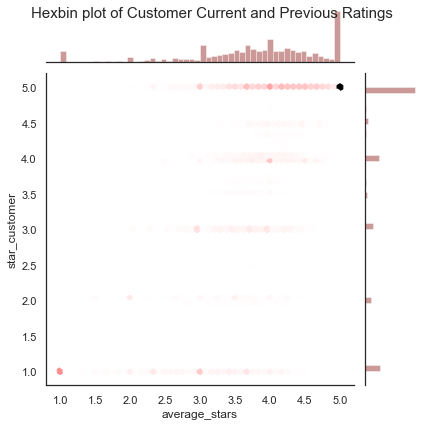

In [554]:
# Hexbin plot
agguser = agg.groupby('user_id')[['star_customer', 'average_stars']].mean()

sns.jointplot(agguser['average_stars'], agguser["star_customer"], 
              kind='hex', color = 'maroon')

plt.suptitle("Hexbin plot of Customer Current and Previous Ratings", fontsize = 15)
#plt.savefig('HexbinPlot of Customer Current and Previous Ratings .png')

In [555]:
agg[['average_stars',"star_customer"]].head(5)

,average_stars,star_customer
0,3.00,4
14,4.58,4
17,3.74,5
18,1.89,1
23,3.83,5


#####  Time Series Detrending

In [556]:
# create quarter index
def quarter(df):
    
    ind = (df["date_yr"]-2017)*4
    
    if df["date_mt"] >= 1 and df["date_mt"] <= 3:
        return ind + 0
    elif df["date_mt"] >= 4 and df["date_mt"] <= 6:
        return ind + 1
    elif df["date_mt"] >= 7 and df["date_mt"] <= 9:
        return ind + 2
    else:
        return ind + 3
    
agg["quarter"] = agg.apply(quarter, axis = 1)
aggdate = agg.groupby(["quarter"])[["star_customer"]].mean()
aggdate

,star_customer
quarter,
0,3.862575
1,3.830659
2,3.837612
3,3.863317


In [557]:
agg.columns

Index(['business_id', 'name_x', 'neighborhood', 'address', 'latitude',
       'longitude', 'star_bus', 'cts_bus', 'categories', 'review_id',
       'user_id', 'star_customer', 'date', 'text', 'useful_x', 'funny_x',
       'cool_x', 'name_y', 'review_count_y', 'yelping_since', 'friends',
       'useful_y', 'funny_y', 'cool_y', 'fans', 'elite', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos', 'DATE', 'date_yr', 'date_mt',
       'quarter'],
      dtype='object')

In [558]:
avg_score_by_quarter =  agg.groupby(["quarter"])[["star_customer"]].mean().values

# Calculate the average growth rate in salaries across all quarters
avg_growth_rate = ((avg_score_by_quarter[1:] - avg_score_by_quarter[:-1]) / avg_score_by_quarter[:-1]).mean()

# Divide each salary by (1 + avg_growth_rate) ** (grad_year - baseline)
agg['rate'] = (1 + avg_growth_rate) ** (agg.quarter-0)
#agg['star_cus'] = agg['star_bus']/agg['rate']
agg['star_customer_2'] = agg['star_customer']/agg['rate']

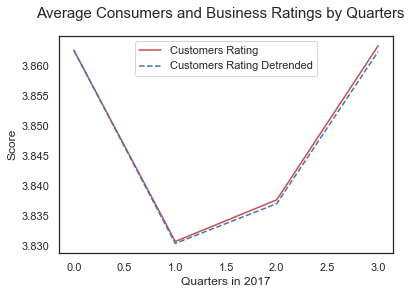

In [559]:
aggdate = agg.groupby(["quarter"])[["star_customer", "star_customer_2"]].mean()
plt.plot(aggdate.index, aggdate["star_customer"], '-r', label = 'Customers Rating')
plt.plot(aggdate.index, aggdate["star_customer_2"], '--b', label = 'Customers Rating Detrended')
plt.suptitle("Average Consumers and Business Ratings by Quarters", fontsize = 15)
plt.legend()
plt.xlabel("Quarters in 2017")
plt.ylabel("Score")
plt.savefig("Average Consumers and Business Ratings by Quarters.png")

##### Normalization and Rescaling

Customers have different rating standards. So a rating of 3 could mean different satisfaction by two customers, if one has average ratings of 5 (implying dissatisfaction) and the other has average rating of 1 (implying satisfaction). We solve this by reweighting the individual ratings by their average ratings.

In [560]:
# reweighed and rescaled consumer satisfaction measure

# a. Account for the "extra" part deviated from the average ratings
agg['y2'] = agg['star_customer'] + (agg['star_customer']-agg['average_stars'])/agg['average_stars']

# b. Normalization
agg['normy'] = (agg['y2'] - np.mean(agg['y2']))/np.std(agg['y2'])

# c. Rescale to 0-100 
agg['y'] = ((100 - 0) / (max(agg['normy'] ) - min(agg['normy'] ))) * (agg['normy'] - min(agg['normy'])) + 0 

##### Test cases

In [561]:
# case when relative rating is high
agg[['average_stars',"star_customer", "y2", "normy", "y"]][agg['y']==100]

,average_stars,star_customer,y2,normy,y
116773,1.36,5,7.676471,2.209572,100.0


In [562]:
# case when relative rating is low
agg[['average_stars',"star_customer", "y2", "normy", "y"]][agg['y']==0]

,average_stars,star_customer,y2,normy,y
588474,4.9,1,0.204082,-2.11435,0.0


##### Summary statistics

In [563]:
# statistics of original scores and transformed scores
agg[['star_customer','y']].describe()

,star_customer,y
count,181144.000000,181144.000000
mean,3.847006,48.898888
std,1.427706,23.127218
min,1.000000,0.000000
25%,3.000000,34.516514
50%,4.000000,55.686422
75%,5.000000,66.730929
max,5.000000,100.000000


In [564]:
# abbreviation

# Y is the categorical star rating
Y = agg["star_customer"]

# y is the reweighted numerical grade with 0-100 scale
y = agg['y']

Text(0.5, 0.98, 'Histogram of the Consumer Satisfaction Score')

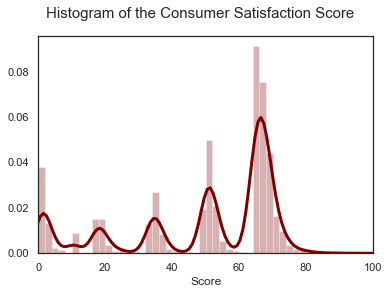

In [565]:
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':3})

sns.distplot(y, color="maroon", label="score", **kwargs)
plt.xlim(0,100)
plt.xlabel("Score")
plt.suptitle("Histogram of the Consumer Satisfaction Score", fontsize=15)
#plt.savefig("Histogram of the Consumer Satisfaction Score.png")

### Independent variables (X: users' inputs)

##### Popularity 

We use `star_bus` (restaurants average ratings) and `cts_bus` (review counts) to measure popularity.  

Customers might prefer to choose the restaurants that are popular (above average ratings and review counts).

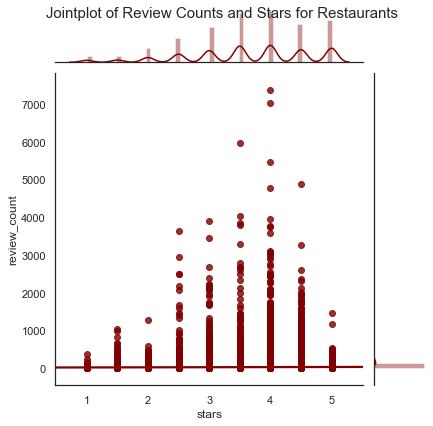

In [566]:
# hexagonal bins
sns.jointplot(bus['stars'], bus['review_count'],kind = "reg", color = "maroon")
plt.suptitle("Jointplot of Review Counts and Stars for Restaurants", fontsize=15)
plt.savefig("stars_review.png")

In [567]:
X = agg[['business_id', 'cts_bus', 'star_bus']]
X['y'] = y

In [568]:
X['popular'] = np.where( (X['star_bus'] > np.mean(X['star_bus'])) & (X['cts_bus'] > 0.4*np.mean(X['cts_bus'])), 1, 0)
X['popular'] .describe()

count    181144.000000
mean          0.418330
std           0.493286
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: popular, dtype: float64

In [569]:
X = X.drop(['cts_bus', 'star_bus'], axis = 1)

##### Gender

In [570]:
guess = gender.Detector()
agg["guess"] = [guess.get_gender(i) for i in agg["name_y"]]
X['gender'] = np.where(agg["guess"].str.contains("female"), 1, 0)
print("Ratio of females inferred from the names:",
      round(X['gender'].sum()/X.shape[0], 2))

Ratio of females inferred from the names: 0.45


##### Weekend 

In [571]:
# Monday 0 to Sunday 6
# Hypothesis: reviews written on Friday, Saturday, and Sunday are different from the ones written during weekdays
agg["dayofweek"] = agg["DATE"].dt.dayofweek
agg["dayofweek"].head()

0     0
14    2
17    3
18    3
23    4
Name: dayofweek, dtype: int64

In [572]:
def weekend(df):
    
    if df["dayofweek"] == 4:
        return 1
    elif df["dayofweek"] == 5:
        return 1
    elif df["dayofweek"] == 6:
        return 1   
    else:
        return 0

In [573]:
X["weekend"] = agg.apply(weekend, axis=1)
X["weekend"].value_counts()

0    98722
1    82422
Name: weekend, dtype: int64

##### Vegan-friendly

Keywords inspired from: https://www.allrecipes.com/recipes/265/everyday-cooking/vegetarian/main-dishes/

In [574]:
veg_keywords = ["vegan", "animal-free", "vegetarian",  
                "flexitarian", "pescetarian", "freegan", "veggie",
                "vegetables", "tofu", "chickpea", "eggplant", 
                "salad", "falafels", "bean", "spinach", 
                "zucchini", "spinach", "pepper", "lentil", 
                "mushroom", "onion"]

def vegan(df):
    
    vocas = [i.lower() for i in df['text'].split()]
    
    for key in veg_keywords:         
        if key in vocas:
            return 1  
    return 0
        
# create new column for food categories
X["vegan"] = agg.apply(vegan, axis=1)

In [575]:
X["vegan"].value_counts()

0    159734
1     21410
Name: vegan, dtype: int64

##### Kids-friendly

In [576]:
kid_keywords = ["child", "children", "kid", "kids", 
                "kid's", "kid-friendly", "baby", "kid-size"]

def kid(df):
    
    vocas = [i.lower() for i in df['text'].split()]
    
    for key in kid_keywords:         
        if key in vocas:
            return 1  
    return 0
        
# create new column for food categories
X["kid"] = agg.apply(kid, axis=1)

In [577]:
X["kid"].value_counts()

0    176338
1      4806
Name: kid, dtype: int64

##### With group

In [578]:
keywords = ["we", "our", "us", "daughter", "son", "children", "kids", "family",
           "friends", "friend", "guests", "buddy", "colleagues", "wife", "husband",
            "partner", "birthday", "group", "party"]

def withgroup(df):
    
    vocas = [i.lower() for i in df['text'].split()]
    
    for key in keywords:         
        if key in vocas:
            return 1  
    return 0
        
# create new column for food categories
X["group"] = agg.apply(withgroup, axis=1)

In [579]:
X["group"].value_counts()

1    91905
0    89239
Name: group, dtype: int64

##### Food Categories

In [580]:
Ameri = ["American (New)", "American (Traditional)", "Burgers", "Chicken Wings",
        "Fast Food", "Hot Dogs", "Salad", "Sandwiches", "Barbeque"
         "Smokehouse", "Pizza", "Cheesesteaks", "Cafeteria"]
Europ = ["Italian", "French", "British", "Hungarian", "lombian","Portuguese", "German",
         "Russian", "Spanish", "Ukrainian", "Fish & Chips", 
         "Greek", "Irish", "Modern European", "Polish", "Bulgarian", "Armenian"]
SouAM = ["Mexican", "Argentine", "Cajun", "Caribbean", "Peruvian",
         "Honduran", "Salvadoran", "Venezuelan", "Puerto Rican", "Tex-Mex", 
         "New Mexican Cuisine", "Nicaraguan", "Tacos", "Latin American"]
Asian = ["Thai", "Japanese", "Fusion", "Korean",
          "Filipino", "Hawaiian", "Curry", "Asian", "Pan Asian",
         "Soba", "Vietnamese", "Singaporean", "Mongolian", 
         "Guamanian", "Himalayan/Nepalese", "Malaysian",
         "Middle Eastern", "Sushi Bars", "Hong Kong Style Cafe", "Bubble Tea"]
Indian = ['Indian']
Chinese = ["Chinese",  "Taiwanese", "Cantonese", "Shanghainese", "Szechuan",
          "Dim Sum", "Ramen", "Hot Pot"]
MidEas = ["Mediterranean","Kebab", "Pakistani", "Persian/Iranian", "Falafel", "Lebanese"]
Drinks = ["Beer", "Coffee", "Wine Bars", "Pubs",  "Wineries", 
          "Wine & Spirits", "Tea Rooms", "Irish Pub", "Juice Bars & Smoothies", "Bars"]

def fooddummy(df, keywords):
    for key in keywords: 
        if key in df['categories']:
            return 1     
    return 0

# Full List (Too slow to run through)
FoodCate = ["Ameri", "Europ", "SouAM", "Asian", 
            "Indian", "Chinese", "MidEas", "Drinks"]

FoodCateKeys = [Ameri, Europ, SouAM, Asian, 
                Indian, Chinese, MidEas, Drinks]

#Simplified List (Just pick two most unique categories)
#FoodCate = ["Asian", "Drinks"]
#FoodCateKeys = [Asian, Drinks]

#c reate new column for food categories
for index, name in enumerate(FoodCate):
    X[name] = agg.apply(fooddummy, args=(FoodCateKeys[index],), axis=1)

In [581]:
def category(df):
    
    if df['Ameri'] == 1:
        return 'American'
    elif df['Europ'] == 1:
        return 'Europe'
    elif df['SouAM'] == 1:
        return 'South American'
    elif df['Asian'] == 1:
        return 'Asian'
    elif df['Indian'] == 1:
        return 'Indian'
    elif df['Chinese'] == 1:
        return 'Chinese'
    elif df['MidEas'] == 1:
        return 'Middle East'
    elif df['Drinks'] == 1:
        return 'Bars & Drinks'
    else:
        return 'Others'
    
X['category'] = X.apply(category, axis = 1)

In [582]:
X['category'].value_counts()

American          88382
Asian             34509
Europe            15237
South American    15033
Others            13998
Bars & Drinks      6608
Chinese            4902
Indian             1636
Middle East         839
Name: category, dtype: int64

In [583]:
X = X.drop(["category"], axis=1)

### Machine Learning

The ML algorithm will predict our satisfaction (utility) from dining at a particular restaurant. The predicted score will be used to rank the filtered options.

#### Preview data

In [584]:
X.head()

,business_id,y,popular,gender,weekend,vegan,kid,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks
0,Pd52CjgyEU3Rb8co6QfTPw,55.260128,0,1,0,0,0,0,1,0,0,0,0,0,0,1
14,4srfPk1s8nlm1YusyDUbjg,49.104521,0,0,0,0,0,1,1,0,0,0,0,0,0,0
17,4srfPk1s8nlm1YusyDUbjg,68.690439,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18,4srfPk1s8nlm1YusyDUbjg,4.349598,0,0,0,0,0,0,1,0,0,0,0,0,0,0
23,n7V4cD-KqqE3OXk0irJTyA,68.270019,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [585]:
bus_agg = X.groupby('business_id').mean()
bus_agg

,y,popular,gender,weekend,vegan,kid,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks
business_id,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,53.662383,1.0,0.383562,0.486301,0.198630,0.006849,0.698630,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
-1m9o3vGRA8IBPNvNqKLmA,63.648997,0.0,0.289474,0.473684,0.368421,0.026316,0.684211,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-3zffZUHoY8bQjGfPSoBKQ,52.227558,1.0,0.444444,0.444444,0.185185,0.037037,0.722222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-8R_-EkGpUhBk55K9Dd4mg,51.563956,0.0,0.482759,0.310345,0.068966,0.000000,0.275862,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
-9YyInW1wapzdNZrhQJ9dg,32.578294,0.0,0.305556,0.472222,0.138889,0.027778,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zp-K5s3pGTWuuaVBWo6WZA,51.030541,0.0,0.700000,0.500000,0.000000,0.000000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zpoZ6WyQUYff18-z4ZU1mA,62.801442,1.0,0.400000,0.427586,0.158621,0.000000,0.303448,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zsQk990PubOHjr1YcLkQFw,48.176130,0.0,0.458333,0.291667,0.125000,0.000000,0.250000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [586]:
XX = bus_agg.drop(['y'], axis=1)
y = bus_agg['y']

In [587]:
XX.describe()

,popular,gender,weekend,vegan,kid,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks
count,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000,3778.000000
mean,0.120699,0.429435,0.460225,0.094083,0.029403,0.409945,0.570143,0.091583,0.157755,0.161196,0.008470,0.078878,0.027263,0.241133
std,0.325820,0.185518,0.189721,0.121264,0.070822,0.221969,0.495121,0.288474,0.364560,0.367761,0.091655,0.269583,0.162871,0.427827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.380952,0.000000,0.000000,0.254635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.437500,0.461289,0.063830,0.000000,0.418275,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.500000,0.536585,0.142857,0.032258,0.558285,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [588]:
y[:10]

business_id
--9e1ONYQuAa-CB_Rrw7Tw    53.662383
-1m9o3vGRA8IBPNvNqKLmA    63.648997
-3zffZUHoY8bQjGfPSoBKQ    52.227558
-8R_-EkGpUhBk55K9Dd4mg    51.563956
-9YyInW1wapzdNZrhQJ9dg    32.578294
-AD5PiuJHgdUcAK-Vxao2A    49.972100
-ADtl9bLp8wNqYX1k3KuxA    53.280407
-Bf8BQ3yMk8U2f45r2DRKw    42.256620
-Bv-HHUs8aHzDrdWcZHn8w    36.140218
-C8sSrFqaCxp51pyo-fQLQ    55.804888
Name: y, dtype: float64

In [589]:
# make sure the rows number match!
(XX.shape, y.shape)

((3778, 14), (3778,))

#### Predictive Models

##### Feature importance using Random Forest

Random Forest measures the relative importance of each predictor by counting the number of associated training samples in the 100 trees. 

In [590]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators = 100,n_jobs = 4).fit(XX, y)

for name,score in zip(XX.columns, rfc.feature_importances_):
    print(name,score)

popular 0.04407574782482792
gender 0.17793705062169654
weekend 0.16618971219993978
vegan 0.1504590396034719
kid 0.07182938840988573
group 0.17993214701095417
Ameri 0.08896729972186974
Europ 0.015687785687992544
SouAM 0.028720141974027374
Asian 0.018862168443139486
Indian 0.0007163967779305
Chinese 0.014998956479450255
MidEas 0.005654117618205751
Drinks 0.03597004762660817


In [591]:
def render_mpl_table(data, col_width = 3.0, row_height = 0.625, font_size = 14,
                     header_color = '#40466e', row_colors = ['#f1f1f2', 'w'], edge_color = 'w',
                     bbox = [0, 0, 1, 1], header_columns = 0, ax = None, **kwargs):
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText = data.values, bbox = bbox, colLabels = data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight = 'bold', color = 'w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

#render_mpl_table(XG, header_columns=0, col_width=2.0)
#plt.savefig('gendertable.png')

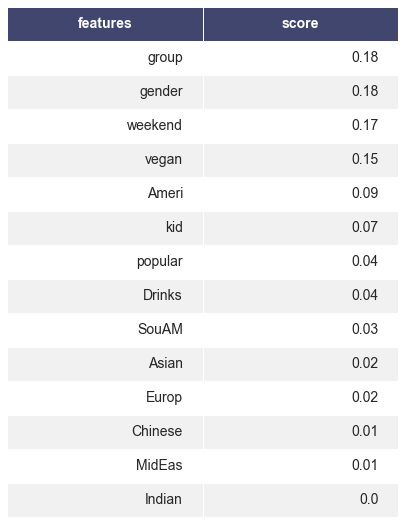

In [592]:
imp = pd.DataFrame({"features": XX.columns, "score": rfc.feature_importances_})
imp = imp.sort_values(by='score', ascending=False)
imp = imp.round(2)
render_mpl_table(imp, header_columns=0, col_width=3.5)
plt.savefig('importance.png')

Text(0.5, 0, 'scores')

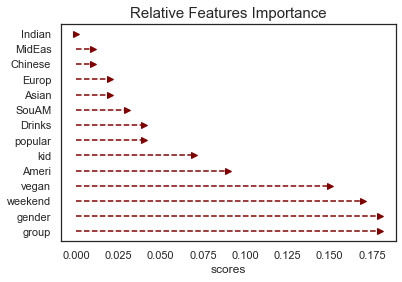

In [593]:
plt.hlines(y = imp["features"], xmin = 0, xmax = imp['score'],
           linestyles = 'dashed', color = 'maroon')

plt.plot(imp['score'], imp["features"], ">", color = 'maroon')
 
plt.yticks(imp["features"])
plt.title("Relative Features Importance", loc = 'center', fontsize = 15)
plt.xlabel('scores')
#plt.savefig("Relative Features Importance.png")

##### Training and testing sets

In [594]:
# Divide the data into training and test set, with ratio 3:1 (test=25%).
X_train, X_test, y_train, y_test = train_test_split(XX, y, random_state = 0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [600]:
XX

,popular,gender,weekend,vegan,kid,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks
business_id,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,1.0,0.383562,0.486301,0.198630,0.006849,0.698630,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
-1m9o3vGRA8IBPNvNqKLmA,0.0,0.289474,0.473684,0.368421,0.026316,0.684211,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-3zffZUHoY8bQjGfPSoBKQ,1.0,0.444444,0.444444,0.185185,0.037037,0.722222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-8R_-EkGpUhBk55K9Dd4mg,0.0,0.482759,0.310345,0.068966,0.000000,0.275862,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
-9YyInW1wapzdNZrhQJ9dg,0.0,0.305556,0.472222,0.138889,0.027778,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zp-K5s3pGTWuuaVBWo6WZA,0.0,0.700000,0.500000,0.000000,0.000000,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zpoZ6WyQUYff18-z4ZU1mA,1.0,0.400000,0.427586,0.158621,0.000000,0.303448,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zsQk990PubOHjr1YcLkQFw,0.0,0.458333,0.291667,0.125000,0.000000,0.250000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### Linear Regression

In [601]:
lin = LinearRegression().fit(X_train, y_train)

In [602]:
linkf = cross_val_score(lin, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-linkf.mean(),2))
print("Standard deviation:",round(linkf.std(),2))

Mean: 211.23
Standard deviation: 9.14


In [604]:
# What happends if we use the full data: much higher s.d
linfull = LinearRegression().fit(XX, y)
linkffull = cross_val_score(linfull, XX, y, cv = 5, 
                      scoring = "neg_mean_squared_error")
print("Mean:",round(-linkffull.mean(),2))
print("Standard deviation:",round(linkffull.std(),2))

Mean: 216.61
Standard deviation: 6.18


In [605]:
lin.coef_

array([  8.4242329 ,   2.15133536,  -3.5276035 ,  11.01617932,
       -21.05550855,   8.04501439,  -6.3856036 ,   1.34823088,
         1.03609374,   3.25140727,   0.67469591,  -1.73286128,
         4.90343466,   3.07366556])

In [606]:
lin.intercept_

40.23633622491625

In [607]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
model = sm.OLS(y_train, X2).fit()
#predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     43.53
Date:                Fri, 20 Mar 2020   Prob (F-statistic):          5.58e-109
Time:                        23:49:35   Log-Likelihood:                -11582.
No. Observations:                2833   AIC:                         2.319e+04
Df Residuals:                    2818   BIC:                         2.328e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.2363      1.205     33.389      0.0

##### Lasso Regression


In [608]:
las = Lasso().fit(X_train, y_train)

In [609]:
alpha_grid = {"alpha": np.linspace(0,20,50)}
grid_search_las = GridSearchCV(las, param_grid = alpha_grid, n_jobs = 4, cv = 5,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)

print('GridBestEstimatorLasso=', grid_search_las.best_estimator_)
print('GridBestParamsLasso=', grid_search_las.best_params_)
print('GridBestScoreLasso=', -grid_search_las.best_score_)

GridBestEstimatorLasso= Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
GridBestParamsLasso= {'alpha': 0.0}
GridBestScoreLasso= 211.22414704575408


In [610]:
las = Lasso(alpha = grid_search_las.best_params_['alpha']).fit(X_train, y_train)
laskf = cross_val_score(las, X_train, y_train, cv = 5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-laskf.mean(),2))
print("Standard deviation:",round(laskf.std(),2))

Mean: 211.23
Standard deviation: 9.14


In [611]:
las.coef_

array([  8.4242329 ,   2.15133536,  -3.5276035 ,  11.01617932,
       -21.05550855,   8.04501439,  -6.3856036 ,   1.34823088,
         1.03609374,   3.25140727,   0.67469591,  -1.73286128,
         4.90343466,   3.07366556])

##### Ridge Regression

In [612]:
rid = Ridge(alpha = 1).fit(X_train, y_train)

In [613]:
alpha_grid = {"alpha": np.linspace(1,20,50)}
grid_search_rid = GridSearchCV(rid, param_grid = alpha_grid, n_jobs = 4, cv = 5,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)
print('GridBestEstimatorRidge=', grid_search_rid.best_estimator_)
print('GridBestParamsRidge', grid_search_rid.best_params_)
print('GridBestScoreRidge=', -grid_search_rid.best_score_)

GridBestEstimatorRidge= Ridge(alpha=2.5510204081632653, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
GridBestParamsRidge {'alpha': 2.5510204081632653}
GridBestScoreRidge= 211.12848756133656


In [614]:
rid = Ridge(alpha = grid_search_rid.best_params_['alpha']).fit(X_train, y_train)
ridkf = cross_val_score(rid, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error")
print("Mean:", round(-ridkf.mean(),2))
print("Standard deviation:", round(ridkf.std(),2))

Mean: 211.13
Standard deviation: 8.97


##### Bayesian Ridge Regression

https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html#sphx-glr-auto-examples-linear-model-plot-bayesian-ridge-py

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.27.9072&rep=rep1&type=pdf

In [615]:
bay = BayesianRidge().fit(X_train, y_train)
baykf = cross_val_score(bay, X_train, y_train, cv = 5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-baykf.mean(),2))
print("Standard deviation:", round(baykf.std(),2))

Mean: 211.3
Standard deviation: 8.83


##### Elastic Net

In [616]:
ela = ElasticNet(alpha = 1,l1_ratio = 0.5).fit(X_train, y_train)

alpha_ratio_grid = {"alpha": np.linspace(0,1,10),
                  "l1_ratio": np.linspace(0,1,10)}

grid_search_ela = RandomizedSearchCV(ela, param_distributions = alpha_ratio_grid, 
                       n_jobs = 4, cv = 5, random_state = 25,
                       scoring='neg_mean_squared_error').fit(X_train,y_train)

print('GridBestEstimator=', grid_search_ela.best_estimator_)
print('GridBestParams=', grid_search_ela.best_params_)
print('GridBestScore=', -grid_search_ela.best_score_)

ela = ElasticNet(alpha = grid_search_ela.best_params_['alpha'],
                l1_ratio = grid_search_ela.best_params_['l1_ratio']).fit(X_train, y_train)

elakf = cross_val_score(ela, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Mean:",round(-elakf.mean(),2))
print("Standard deviation:",round(elakf.std(),2))

GridBestEstimator= ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True,
      l1_ratio=0.6666666666666666, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
GridBestParams= {'l1_ratio': 0.6666666666666666, 'alpha': 0.0}
GridBestScore= 211.22414704575408
Mean: 211.23
Standard deviation: 9.14


##### Decision Tree

In [617]:
tree = DecisionTreeRegressor().fit(X_train, y_train)

In [618]:
param_dist_tree = {'max_depth': sp_randint(2, 100),
               'min_samples_split': sp_randint(2, 100),
               'min_samples_leaf': sp_randint(2, 100)}

random_search_tree = RandomizedSearchCV(tree, param_distributions = param_dist_tree,
                       n_jobs = 4, cv = 5, random_state = 25,
                       scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorTree=', random_search_tree.best_estimator_)
print('RandBestParamsTree=', random_search_tree.best_params_)
print('RandBestScoreTree=', -random_search_tree.best_score_)

RandBestEstimatorTree= DecisionTreeRegressor(criterion='mse', max_depth=49, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=75,
           min_samples_split=18, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
RandBestParamsTree= {'max_depth': 49, 'min_samples_leaf': 75, 'min_samples_split': 18}
RandBestScoreTree= 208.12134954903203


In [619]:
tree = DecisionTreeRegressor(max_depth = random_search_tree.best_params_['max_depth'],
                             min_samples_leaf = random_search_tree.best_params_['min_samples_leaf'],
                             min_samples_split = random_search_tree.best_params_['min_samples_split']).fit(X_train, y_train)

In [620]:
treekf = cross_val_score(tree, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-treekf.mean(),2))
print("Standard deviation:", round(treekf.std(),2))

Mean: 208.12
Standard deviation: 15.49


##### Random Forest

In [621]:
rfr = RandomForestRegressor().fit(X_train, y_train)

In [622]:
param_dist_rfr = {'n_estimators':sp_randint(10, 100),
               'max_depth': sp_randint(5, 10),
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20),
               'max_features':sp_randint(1,5)}

random_search_rfr = RandomizedSearchCV(rfr, param_distributions = param_dist_rfr,
                        n_jobs = 4, cv = 5, random_state = 25,
                       scoring = 'neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorrfr=', random_search_rfr.best_estimator_)
print('RandBestParamsrfr=', random_search_rfr.best_params_)
print('RandBestScorerfr=', -random_search_rfr.best_score_)

RandBestEstimatorrfr= RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=12,
           min_samples_split=19, min_weight_fraction_leaf=0.0,
           n_estimators=24, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
RandBestParamsrfr= {'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 12, 'min_samples_split': 19, 'n_estimators': 24}
RandBestScorerfr= 200.1814528379231


In [623]:
bprfr = random_search_rfr.best_params_
rfr = RandomForestRegressor(max_depth = bprfr['max_depth'],
                             max_features = bprfr['max_features'],
                             min_samples_leaf = bprfr['min_samples_leaf'],
                             min_samples_split = bprfr['min_samples_split']).fit(X_train, y_train)

In [624]:
rfrkf = cross_val_score(rfr, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:",round(-rfrkf.mean(),2))
print("Standard deviation:",round(rfrkf.std(),2))

Mean: 201.96
Standard deviation: 10.79


##### Gradient Boosting

In [625]:
gra = GradientBoostingRegressor(random_state=10, n_estimators=50,).fit(X_train,y_train) 

In [626]:
param_dist_gra = {'max_depth': sp_randint(1, 5),
                  'n_estimators': sp_randint(20,100),
                   'learning_rate': np.linspace(0.2, 0.8, 10),
                   'alpha': np.linspace(0.2, 0.9, 10) }

random_search_gra = RandomizedSearchCV(estimator = GradientBoostingRegressor(),
                    param_distributions = param_dist_gra, n_jobs = 4,iid=False, 
                    cv=5, random_state=25, scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimatorxgb=', random_search_gra.best_estimator_)
print('RandBestParamsxgb=', random_search_gra.best_params_)
print('RandBestScorexgb=', -random_search_gra.best_score_)

RandBestEstimatorxgb= GradientBoostingRegressor(alpha=0.43333333333333335, criterion='friedman_mse',
             init=None, learning_rate=0.46666666666666673, loss='ls',
             max_depth=2, max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=23,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)
RandBestParamsxgb= {'alpha': 0.43333333333333335, 'learning_rate': 0.46666666666666673, 'max_depth': 2, 'n_estimators': 23}
RandBestScorexgb= 201.41925302500016


In [627]:
gra = GradientBoostingRegressor(alpha = random_search_gra.best_params_['alpha'],
                    learning_rate = random_search_gra.best_params_['learning_rate'],
                    max_depth = random_search_gra.best_params_['max_depth'],
                    n_estimators = random_search_gra.best_params_['n_estimators']).fit(X_train, y_train)

In [628]:
grakf = cross_val_score(gra, X_train, y_train, cv = 5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-grakf.mean(),2))
print("Standard deviation:", round(grakf.std(),2))

Mean: 201.48
Standard deviation: 11.16


##### Multi-layer Perceptron

In [629]:
from sklearn.neural_network import MLPRegressor
mlp= MLPRegressor(activation='tanh', solver='lbfgs', alpha=0.1).fit(X_train, y_train)

In [630]:
param_dist_mlp = {'hidden_layer_sizes':sp_randint(10, 100),
               'activation':["logistic", "relu"],
               'alpha': sp_uniform(0.1, 10.0)}

random_search_mlp = RandomizedSearchCV(mlp, param_distributions = param_dist_mlp,
                       n_jobs = 4, cv = 5, random_state = 25,
                       scoring='neg_mean_squared_error').fit(X_train, y_train)

print('RandBestEstimator5=', random_search_mlp.best_estimator_)
print('RandBestParams5=', random_search_mlp.best_params_)
print('RandBestScore5=', -random_search_mlp.best_score_)

RandBestEstimator5= MLPRegressor(activation='logistic', alpha=5.954451165110356,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=11, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
RandBestParams5= {'activation': 'logistic', 'alpha': 5.954451165110356, 'hidden_layer_sizes': 11}
RandBestScore5= 207.06814386864818


In [631]:
mlp = MLPRegressor(hidden_layer_sizes = random_search_mlp.best_params_['hidden_layer_sizes'],
                           activation = random_search_mlp.best_params_['activation'],
                                alpha = random_search_mlp.best_params_['alpha']).fit(X_train, y_train)

In [632]:
mlpkf = cross_val_score(mlp, X_train, y_train, cv=5, 
                      scoring="neg_mean_squared_error")
print("Mean:", round(-mlpkf.mean(),2))
print("Standard deviation:", round(mlpkf.std(),2))

Mean: 500.09
Standard deviation: 22.16


#### Model Comparsion

#### Note:
Models that we didn't report as they produced higher MSE:
KNN, XGboost, Adaboost, SVM

In [633]:
results = pd.DataFrame({'CV MSE':[-treekf.mean(), -rfrkf.mean(), -grakf.mean(),
                                -laskf.mean(), -ridkf.mean(), -baykf.mean(), -elakf.mean(), -mlpkf.mean()],
                      
                      'CV Std':[treekf.std(), rfrkf.std(), grakf.std(), 
                                laskf.std(), ridkf.std(), baykf.std(), elakf.std(), mlpkf.std()], 
                      
                     'Name':["Decision Tree","Random Forest","Gradient Boosting", 
                             "Lasso Regression", "Ridge Regression", "Bayesian Ridge", 
                            "Elastic Net",  "Multi-layer Perceptrons"],
                     
                     'Class':['Tree', 'Tree', 'Boosting', 'Linear', 'Linear', 
                              'Bayeisan', 'Linear', 'Neural Nets'],})
                     
results

,CV MSE,CV Std,Name,Class
0,208.124713,15.485800,Decision Tree,Tree
1,201.959606,10.786036,Random Forest,Tree
2,201.480665,11.160468,Gradient Boosting,Boosting
3,211.228956,9.140622,Lasso Regression,Linear
4,211.133601,8.966146,Ridge Regression,Linear
5,211.302140,8.834460,Bayesian Ridge,Bayeisan
6,211.228956,9.140622,Elastic Net,Linear
7,500.091499,22.155300,Multi-layer Perceptrons,Neural Nets


<Figure size 432x432 with 0 Axes>

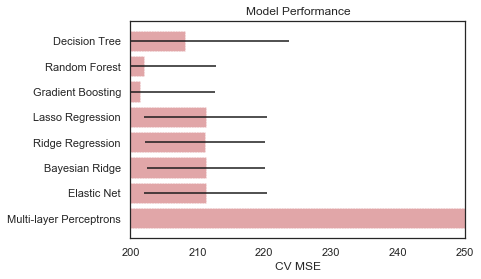

In [634]:
#plt.rcdefaults()
plt.figure(figsize = (6,6))

fig, ax = plt.subplots()

ax.barh(results['Name'], results['CV MSE'], xerr = results['CV Std'],
        align = 'center', color = 'r', alpha = 0.5, ls = ":")
ax.set_xlim([200, 250])
#ax.set_yticklabels(results['Name'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('CV MSE')
ax.set_title('Model Performance')
plt.savefig('Performance.png')

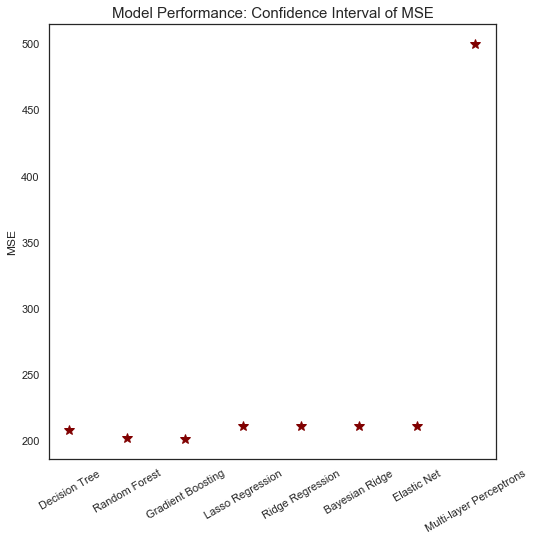

In [635]:
plt.figure(figsize = (8,8))

ind = results['Name']
mse = results['CV MSE']
err = results['CV Std']*1.96/np.sqrt(len(X))

plt.errorbar(ind, mse, err, linestyle = 'None', marker = '*',  mfc = 'maroon',
         mec='maroon', ms = 10, mew = 1, ls=':')

plt.xticks(rotation = 30)
plt.ylabel('MSE')
plt.title('Model Performance: Confidence Interval of MSE', fontsize = 15)
plt.savefig('Model Performance.png')

Random forest performs the best!

#### Performance on test set

In [636]:
mean_squared_error(rfr.predict(X_test), y_test)

224.43736257168092

In [637]:
end = time.time()
print("Minutes to run",(end-start)/60)

Minutes to run 6.214104314645131


### Predict the scores

In [638]:
XX['utility'] = rfr.predict(XX)

In [639]:
np.corrcoef(XX['utility'],y)[0,1]

0.5149654872146346

In [640]:
LVR.shape

(3990, 9)

In [641]:
XX.shape

(3778, 15)

In [642]:
restaurants = pd.merge(LVR, XX, how = 'left', left_on = LVR['business_id'], right_on = XX.index)

### Export data and model

In [643]:
XX.head()

,popular,gender,weekend,vegan,kid,group,Ameri,Europ,SouAM,Asian,Indian,Chinese,MidEas,Drinks,utility
business_id,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,1.0,0.383562,0.486301,0.198630,0.006849,0.698630,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,53.441547
-1m9o3vGRA8IBPNvNqKLmA,0.0,0.289474,0.473684,0.368421,0.026316,0.684211,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,42.919872
-3zffZUHoY8bQjGfPSoBKQ,1.0,0.444444,0.444444,0.185185,0.037037,0.722222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.631174
-8R_-EkGpUhBk55K9Dd4mg,0.0,0.482759,0.310345,0.068966,0.000000,0.275862,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,47.136232
-9YyInW1wapzdNZrhQJ9dg,0.0,0.305556,0.472222,0.138889,0.027778,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.814922


In [644]:
# save X data
XX.to_csv("user_features.csv", encoding = 'utf-8', index = False)

In [645]:
# save business data
restaurants.to_csv("restaurants.csv", encoding='utf-8', index = False)

save the model to disk

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [646]:
pickle.dump(rfr, open('random_forest_model.sav', 'wb'))

<IPython.core.display.Javascript object>